# Brown Corpus NLP Analysis



## Overview


For this project I am going to use the Brown Corpus from nltk.

I will first clean the entire Brown Corpus, and then I will group the information into sentences, tokens, documents and genres.

After the initial pre-processing, I will use the TF-IDF method to analyze the words used throughout the Brown Corpus. Following TF-IDF, I will use the LSA method to make cluster of topics. 

I will then use the output from TF-IDF and LSA, I will use Logistic Regression and Random Forest to try to classify the sentences by the genres of the document. 

Finally, I will use K-Means and Spectral Clustering with the output from LSA to see if clusters of the genres can be seen. 

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from matplotlib.mlab import PCA as mlabPCA
import seaborn as sns

import re
from collections import Counter

import spacy
import nltk
from nltk.corpus import brown, stopwords

import sklearn
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

%matplotlib inline

## Loading the data


In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies some form of punctuation spaCy does not recognize
    text = re.sub(r'--',' ',text)
    text = re.sub("/.*? ", " ",text)
    text = re.sub("\\./\\.", "",text)
    text = re.sub("``", "",text)
    text = re.sub("''", "",text)
    text = re.sub("  ", " ",text)
    text = re.sub("./", " ",text)
    text = re.sub("'s", " ",text)
    text = ' '.join(text.split())
    return text

In [3]:
# number of text by genre
genres_raw =[]
for i in brown.categories():
    for j in (brown.fileids(categories=i)):
        genres_raw.append(i)
genres = Counter(genres_raw)


In [4]:
genres

Counter({'adventure': 29,
         'belles_lettres': 75,
         'editorial': 27,
         'fiction': 29,
         'government': 30,
         'hobbies': 36,
         'humor': 9,
         'learned': 80,
         'lore': 48,
         'mystery': 24,
         'news': 44,
         'religion': 17,
         'reviews': 17,
         'romance': 29,
         'science_fiction': 6})

There is a significance imbalance on the numer of documents per category, so I am going use a maximum of 30 documents per category

In [157]:
#load and clean the data
texts = dict()
corpus_full = brown.fileids()
corpus = []
for i in corpus_full:
    if int((i[2:]))<30:
        corpus.append(i)

In [21]:
corpus

['ca01',
 'ca02',
 'ca03',
 'ca04',
 'ca05',
 'ca06',
 'ca07',
 'ca08',
 'ca09',
 'ca10',
 'ca11',
 'ca12',
 'ca13',
 'ca14',
 'ca15',
 'ca16',
 'ca17',
 'ca18',
 'ca19',
 'ca20',
 'ca21',
 'ca22',
 'ca23',
 'ca24',
 'ca25',
 'ca26',
 'ca27',
 'ca28',
 'ca29',
 'cb01',
 'cb02',
 'cb03',
 'cb04',
 'cb05',
 'cb06',
 'cb07',
 'cb08',
 'cb09',
 'cb10',
 'cb11',
 'cb12',
 'cb13',
 'cb14',
 'cb15',
 'cb16',
 'cb17',
 'cb18',
 'cb19',
 'cb20',
 'cb21',
 'cb22',
 'cb23',
 'cb24',
 'cb25',
 'cb26',
 'cb27',
 'cc01',
 'cc02',
 'cc03',
 'cc04',
 'cc05',
 'cc06',
 'cc07',
 'cc08',
 'cc09',
 'cc10',
 'cc11',
 'cc12',
 'cc13',
 'cc14',
 'cc15',
 'cc16',
 'cc17',
 'cd01',
 'cd02',
 'cd03',
 'cd04',
 'cd05',
 'cd06',
 'cd07',
 'cd08',
 'cd09',
 'cd10',
 'cd11',
 'cd12',
 'cd13',
 'cd14',
 'cd15',
 'cd16',
 'cd17',
 'ce01',
 'ce02',
 'ce03',
 'ce04',
 'ce05',
 'ce06',
 'ce07',
 'ce08',
 'ce09',
 'ce10',
 'ce11',
 'ce12',
 'ce13',
 'ce14',
 'ce15',
 'ce16',
 'ce17',
 'ce18',
 'ce19',
 'ce20',
 'ce21',
 

In [22]:
for doc in corpus:
    text = brown.raw(doc)
    text = text_cleaner(text)
    texts[doc] = text

In [23]:
#dic with genre codes and genre
genres_codes ={}
for i in brown.categories():
    fields = (brown.fileids(categories=i))
    genres_codes[fields[0][0:2]] = i


In [24]:
genres_codes

{'cn': 'adventure',
 'cg': 'belles_lettres',
 'cb': 'editorial',
 'ck': 'fiction',
 'ch': 'government',
 'ce': 'hobbies',
 'cr': 'humor',
 'cj': 'learned',
 'cf': 'lore',
 'cl': 'mystery',
 'ca': 'news',
 'cd': 'religion',
 'cc': 'reviews',
 'cp': 'romance',
 'cm': 'science_fiction'}

In [25]:
# Parse using SpaCy
nlp = spacy.load('en_core_web_sm')

In [26]:
# Extract sentences
#Add a variable for the minimum sentence lenght 
docs = {}
sentences = []
for key, value in texts.items():
    docs[key] = nlp(value)
    for sentence in docs[key].sents: 
        clean_sent = [token.lemma_.lower() 
                      for token in sentence 
                      if not token.is_stop 
                      and not token.is_punct]
        if len(clean_sent) > 8:
            sentences += [[' '.join(clean_sent), clean_sent, key]]

In [27]:
# Generate processed dataset
sentences = pd.DataFrame(sentences, columns = ['Sentences','Tokens', 'Document'])
sentences.loc[:,'Genre'] = [genres_codes[doc[:2]] for doc in sentences['Document']]

In [28]:
len(sentences)

13615

In [29]:
sentences.sample(10)

,Sentences,Tokens,Document,Genre
3134,-pron- simply taoist tradition good mysticism ...,"[-pron-, simply, taoist, tradition, good, myst...",cd15,religion
914,american stock exchange price enjoy fairly sol...,"[american, stock, exchange, price, enjoy, fair...",ca27,news
5728,-pron- know conversation author settle questio...,"[-pron-, know, conversation, author, settle, q...",cg12,belles_lettres
9261,aside notification certain major event life ma...,"[aside, notification, certain, major, event, l...",ck23,fiction
10133,not -pron- interrupt call cry help faith const...,"[not, -pron-, interrupt, call, cry, help, fait...",cl14,mystery
1908,this k. doubt keep threaten pull ear responsib...,"[this, k., doubt, keep, threaten, pull, ear, r...",cb25,editorial
2395,"mr. elman 70 year old there 8,000 person stadi...","[mr., elman, 70, year, old, there, 8,000, pers...",cc11,reviews
1736,besides hardly avoid muse instability death ex...,"[besides, hardly, avoid, muse, instability, de...",cb20,editorial
2713,event possibility exclude therefore conceivabl...,"[event, possibility, exclude, therefore, conce...",cd02,religion
48,the bill defender small town legislator like j...,"[the, bill, defender, small, town, legislator,...",ca02,news


Each row has been save in one row in a dataframe along with the Tokens, the document id and the Genre it belongs to.

In [30]:
train, holdout= train_test_split(sentences, test_size=0.25)

print('Train:', len(train))
print('Holdout:', len(holdout))

Train: 10211
Holdout: 3404


# TF-IDF

In [31]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Applying the vectorizer
TfIdf = vectorizer.fit_transform(train['Sentences'])


In [32]:
TfIdf_csr = TfIdf.tocsr()


In [33]:
TfIdf_csr.shape[0]

10211

In [34]:
tfidf_bypara = [{} for _ in range(0,TfIdf_csr.shape[0])]

In [35]:
terms = vectorizer.get_feature_names()


In [36]:
for i, j in zip(*TfIdf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = TfIdf_csr[i, j]

In [37]:
train = train.reset_index()
train = train.drop(['index'], axis=1)
train.sample(2)

,Sentences,Tokens,Document,Genre
6473,-pron- inform kidney trouble liver trouble sev...,"[-pron-, inform, kidney, trouble, liver, troub...",cf10,lore
7589,the stem laminate piece take inch wide piece r...,"[the, stem, laminate, piece, take, inch, wide,...",ce16,hobbies


In [64]:
print('Sentence:\n', train['Sentences'][0], 
      '\nTf_idf vector:\n', tfidf_bypara[0])

Sentence:
 a. o'banion pistol pocket but november 1924 draw close democratic hierarchy sorely trouble grapevine report o'banion woo opposition meet confer important republicans to forestall change allegiance democrats hastily organise testimonial banquet o'banion public reward past service reminder loyalty lie the reception hold private dining room webster hotel lincoln park west 
Tf_idf vector:
 {'banion': 0.4437952106110974, 'pistol': 0.14370642249491197, 'pocket': 0.13591872604904684, 'november': 0.1267639437418505, '1924': 0.17686417641954305, 'draw': 0.10987984720442243, 'close': 0.09904374774368131, 'democratic': 0.12717624483650447, 'hierarchy': 0.16875653883375824, 'sorely': 0.17686417641954305, 'trouble': 0.11483007244856969, 'grapevine': 0.18261663683284282, 'report': 0.10224550732776032, 'woo': 0.17686417641954305, 'opposition': 0.14277621316318287, 'meet': 0.10386599882525202, 'confer': 0.18261663683284282, 'important': 0.10310173148032267, 'republicans': 0.1518140600806967

# LSA

In [52]:
#Our SVD data reducer. Features are reduced down to 500.
svd = TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
LSA = lsa.fit_transform(TfIdf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print(
    'The percentage of total variance in the dataset explained by each',
    'component from LSA.\n',
    variance_explained[:5]
)
print("Percent variance captured by all components:",total_variance*100)

The percentage of total variance in the dataset explained by each component from LSA.
 [0.0041297  0.0030792  0.00292046 0.00227687 0.00214809]
Percent variance captured by all components: 32.6208571998506


In [54]:
Sentence_by_component=pd.DataFrame(LSA)
for i in range(0,2):
    print('Component {}:'.format(i))
    print(Sentence_by_component.loc[i].sort_values(ascending=False)[0:10])


Component 0:
123    0.138234
150    0.127296
100    0.118991
244    0.102617
144    0.101058
232    0.097843
321    0.091668
0      0.091188
97     0.089871
40     0.088440
Name: 0, dtype: float64
Component 1:
7      0.172110
157    0.135756
22     0.113960
26     0.111224
380    0.108597
130    0.108109
151    0.107711
297    0.099903
350    0.099402
182    0.099397
Name: 1, dtype: float64


In [55]:
Sentence_by_component.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10097,0.195956,-0.086655,-0.035699,0.082878,-0.007887,-0.046651,0.150030,0.027858,0.064702,-0.014780,...,0.000562,0.021997,0.003974,-0.020654,0.028610,-0.026310,0.001218,-0.035108,-0.046538,-0.020811
5360,0.099139,-0.121451,-0.030603,0.035346,-0.002193,-0.008974,0.113920,0.098452,0.281740,0.005675,...,0.034490,-0.045561,0.001139,0.057814,0.016802,-0.021828,0.050107,0.019901,0.048677,0.036242
5393,0.223538,0.005237,0.019759,0.101889,-0.048308,-0.093693,-0.058845,-0.067269,-0.011868,-0.050594,...,-0.039400,0.042778,0.001212,-0.008518,-0.010762,0.039963,0.007619,-0.011455,0.055661,-0.034960
5843,0.085578,-0.016268,-0.006182,0.159996,0.015286,-0.102870,0.063906,-0.003761,0.027621,-0.131613,...,0.015684,0.004339,-0.013215,0.014366,0.032597,-0.128973,0.027118,0.068458,0.045093,0.001883
1146,0.072581,-0.075401,-0.032132,0.010638,0.050757,-0.060227,-0.016467,-0.017020,0.067494,0.076091,...,-0.004754,-0.044753,0.050841,-0.031203,0.073541,0.060784,-0.089609,-0.006957,-0.021907,-0.017935


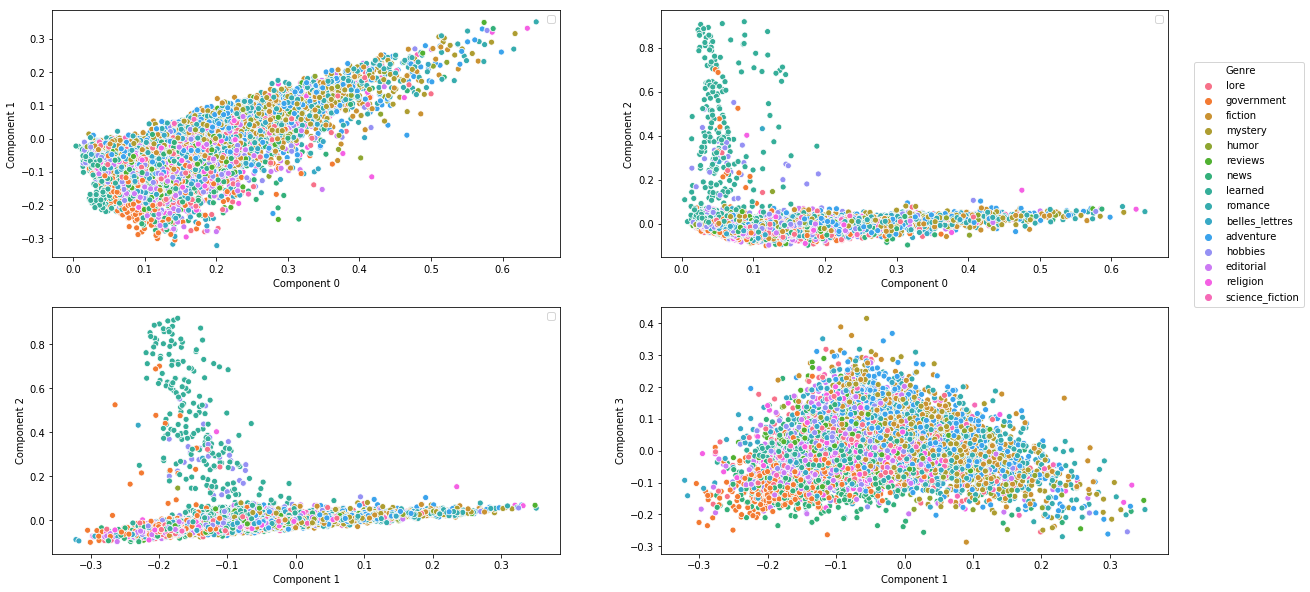

In [42]:
plt.figure(figsize=(20,10))
for i, c in enumerate([(0,1), (0,2), (1,2), (1,3)]): 
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=LSA[:, c[0]], y=LSA[:, c[1]], hue=train['Genre'])
    plt.legend('')
    plt.xlabel('Component ' + str(c[0]))
    plt.ylabel('Component ' + str(c[1]))
plt.legend(loc = (1.05, 1))
plt.show()


In [158]:
# Transform test set 
test_tfidf = vectorizer.transform(holdout['Sentences'])
LSA_test = lsa.transform(test_tfidf)

# model vars
x_train_LSA = LSA
x_test_LSA = LSA_test
y_train = train['Genre']
y_test = holdout['Genre']

After reducing the number of features to 500% using the the LSA methos, it only captures 32% of the total variability. The trade off of having less features and less overfitting is the loss of a lot of information.

# Logistic Regression

Using the output from the LSA and TF-IDF I am going to trade to predict the category of each sentence. 

In [159]:
lr = LogisticRegression(solver='lbfgs', multi_class = 'auto',max_iter=200)
lr.fit(x_train_LSA, y_train)

print('cross-validation:')
cx_val = cross_val_score(lr, x_train_LSA, y_train, cv=5)
print(cx_val)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

print('Training set score:', lr.score(x_train_LSA, y_train))
print('Test set score:', lr.score(x_test_LSA, y_test))
pd.crosstab(y_test, lr.predict(x_test_LSA))

cross-validation:
[0.56152344 0.55452323 0.57464513 0.56372549 0.56019656]
 cx_val lr_score: 0.56 (+/- 0.01)
Training set score: 0.7318578004113211
Test set score: 0.5505287896592245


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,,
adventure,196,4,1,28,0,8,0,0,7,25,6,0,2,52,0
belles_lettres,13,133,11,17,6,15,1,11,13,8,4,5,11,15,0
editorial,8,15,106,7,28,13,0,5,18,12,27,11,6,13,0
fiction,32,11,3,123,0,9,0,1,9,26,4,5,5,62,0
government,0,8,7,1,177,7,0,12,1,0,2,2,0,1,0
hobbies,6,9,12,9,10,165,0,6,10,2,7,3,14,11,0
humor,6,8,2,15,2,5,11,0,4,4,7,3,5,19,0
learned,0,12,0,2,13,3,0,207,2,0,0,2,0,0,0
lore,12,29,16,13,11,15,0,8,122,7,16,4,3,5,0


In [160]:
#Our SVD data reducer. Features are reduced down to 1000 in this case.
svd = TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
LSA = lsa.fit_transform(TfIdf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print(
    'The percentage of total variance in the dataset explained by each',
    'component from LSA.\n',
    variance_explained[:5]
)
print("Percent variance captured by all components:",total_variance*100)

The percentage of total variance in the dataset explained by each component from LSA.
 [0.0041297  0.0030792  0.00292046 0.00227687 0.00214809]
Percent variance captured by all components: 48.481890587747614


In [71]:
Sentence_by_component=pd.DataFrame(LSA)
for i in range(0,2):
    print('Component {}:'.format(i))
    print(Sentence_by_component.loc[i].sort_values(ascending=False)[0:10])


Component 0:
123    0.108012
386    0.100178
150    0.094707
100    0.091560
244    0.088056
602    0.086237
339    0.083683
144    0.081302
935    0.081020
169    0.078532
Name: 0, dtype: float64
Component 1:
7      0.134300
236    0.098478
461    0.097397
157    0.095418
728    0.092608
336    0.092207
151    0.089347
22     0.088936
297    0.088391
130    0.087018
Name: 1, dtype: float64


In [161]:
# Transform test set 
test_tfidf = vectorizer.transform(holdout['Sentences'])
LSA_test = lsa.transform(test_tfidf)

# model vars
x_train_LSA1000 = LSA
x_test_LSA1000 = LSA_test

In [1]:
lr.fit(x_train_LSA1000, y_train)

print('cross-validation:')
cx_val = cross_val_score(lr, x_train_LSA1000, y_train, cv=5)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

print('Training set score:', lr.score(x_train_LSA1000, y_train))
print('Test set score:', lr.score(x_test_LSA1000, y_test))
pd.crosstab(y_test, lr.predict(x_test_LSA1000))

NameError: name 'lr' is not defined

In [163]:
# Transform test set 

# model vars
x_train_TfIdf = TfIdf
x_test_TfIdf = test_tfidf


print('cross-validation:')
cx_val = cross_val_score(lr, x_train_TfIdf, y_train, cv=5)
print(cx_val)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

lr.fit(x_train_TfIdf, y_train)
print('Training set score:', lr.score(x_train_TfIdf, y_train))
print('Test set score:', lr.score(x_test_TfIdf, y_test))
pd.crosstab(y_test, lr.predict(x_test_TfIdf))


cross-validation:
[0.60498047 0.600978   0.59667156 0.60343137 0.6004914 ]
 cx_val lr_score: 0.60 (+/- 0.01)
Training set score: 0.8822838115757516
Test set score: 0.6086956521739131


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,,
adventure,230,5,1,12,0,11,0,0,6,19,3,0,1,41,0
belles_lettres,16,153,7,17,3,16,0,6,12,4,3,4,6,16,0
editorial,6,13,122,9,26,9,0,5,13,10,26,8,5,17,0
fiction,31,6,6,162,0,8,0,2,6,17,5,3,3,41,0
government,0,7,6,1,183,8,0,9,1,0,1,1,0,1,0
hobbies,7,8,12,7,5,185,0,7,6,2,5,1,9,10,0
humor,5,12,4,13,2,5,13,3,5,6,7,0,2,14,0
learned,1,9,2,1,7,4,0,216,0,0,0,0,0,1,0
lore,12,27,11,12,9,14,0,7,143,3,14,2,1,6,0


# Random Forest

In [65]:
rfc = ensemble.RandomForestClassifier(n_estimators =100)
rfc.fit(x_train_LSA, y_train)

print('cross-validation:')
cx_val = cross_val_score(rfc, x_train_LSA, y_train, cv=5)
print(cx_val)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

print('Training set score:', rfc.score(x_train_LSA, y_train))
print('Test set score:', rfc.score(x_test_LSA, y_test))
pd.crosstab(y_test, rfc.predict(x_test_LSA))

cross-validation:
[0.35107422 0.34816626 0.36270191 0.34754902 0.33808354]
 cx_val lr_score: 0.35 (+/- 0.02)
Training set score: 1.0
Test set score: 0.3495887191539365


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,learned,lore,mystery,news,religion,reviews,romance
Genre,,,,,,,,,,,,,
adventure,136,8,4,47,0,16,3,3,31,4,2,0,75
belles_lettres,29,84,23,22,12,14,19,21,9,7,3,2,18
editorial,16,24,66,15,48,10,7,14,10,30,10,1,18
fiction,70,8,5,56,1,13,0,15,35,7,6,2,72
government,3,6,12,4,165,7,9,3,2,5,1,0,1
hobbies,23,19,11,19,19,108,16,10,5,12,2,2,18
humor,13,6,4,10,5,4,3,5,8,5,1,0,27
learned,2,8,4,4,15,11,188,4,1,2,1,1,0
lore,20,30,24,20,21,22,15,49,13,22,4,1,20


In [66]:
rfc.fit(x_train_LSA1000, y_train)

print('cross-validation:')
cx_val = cross_val_score(rfc, x_train_LSA1000, y_train, cv=5)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

print('Training set score:', rfc.score(x_train_LSA1000, y_train))
print('Test set score:', rfc.score(x_test_LSA1000, y_test))
pd.crosstab(y_test, rfc.predict(x_test_LSA1000))

cross-validation:
 cx_val lr_score: 0.34 (+/- 0.01)
Training set score: 1.0
Test set score: 0.33607520564042304


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance
Genre,,,,,,,,,,,,,,
adventure,138,8,5,40,1,10,0,4,14,32,3,1,0,73
belles_lettres,31,68,20,24,14,15,1,27,24,7,6,2,3,21
editorial,19,26,41,24,45,18,0,17,15,14,26,6,2,16
fiction,76,12,12,61,4,17,0,2,3,29,10,4,1,59
government,3,9,10,1,168,8,0,8,2,1,4,0,0,4
hobbies,26,21,14,13,22,113,0,16,10,5,8,1,3,12
humor,17,4,7,18,2,6,0,3,7,9,0,0,1,17
learned,7,8,5,4,15,8,0,188,3,0,0,0,0,3
lore,30,27,29,29,16,23,0,14,52,16,17,1,0,7


In [67]:
cx_val = cross_val_score(rfc, x_train_TfIdf, y_train, cv=5)
print(cx_val)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

rfc.fit(x_train_TfIdf, y_train)
print('Training set score:', rfc.score(x_train_TfIdf, y_train))
print('Test set score:', rfc.score(x_test_TfIdf, y_test))
pd.crosstab(y_test, rfc.predict(x_test_TfIdf))


[0.45996094 0.46552567 0.46402349 0.47205882 0.44324324]
 cx_val lr_score: 0.46 (+/- 0.02)
Training set score: 1.0
Test set score: 0.45593419506462984


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,,
adventure,151,11,2,27,1,11,0,4,3,34,6,3,0,76,0
belles_lettres,25,92,16,15,12,12,0,22,11,4,7,6,7,34,0
editorial,11,17,76,7,38,13,0,9,9,10,32,12,7,28,0
fiction,51,11,7,94,1,12,0,6,9,18,5,8,7,61,0
government,2,10,7,4,157,15,0,12,0,0,5,3,0,3,0
hobbies,17,12,10,16,12,137,0,15,5,5,9,2,14,10,0
humor,7,11,4,10,3,4,16,4,1,5,6,1,3,16,0
learned,3,8,0,3,16,7,0,198,0,0,1,2,0,3,0
lore,25,14,12,14,20,19,0,22,86,7,24,4,2,12,0


In [69]:
rfc = ensemble.RandomForestClassifier(n_estimators =500)

cx_val = cross_val_score(rfc, x_train_TfIdf, y_train, cv=5)
print(cx_val)
print(" cx_val lr_score: %0.2f (+/- %0.2f)" % (cx_val.mean(),cx_val.std() * 2))

rfc.fit(x_train_TfIdf, y_train)
print('Training set score:', rfc.score(x_train_TfIdf, y_train))
print('Test set score:', rfc.score(x_test_TfIdf, y_test))
pd.crosstab(y_test, rfc.predict(x_test_TfIdf))

[0.46826172 0.47237164 0.48849731 0.47941176 0.46732187]
 cx_val lr_score: 0.48 (+/- 0.02)
Training set score: 1.0
Test set score: 0.4782608695652174


col_0,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
Genre,,,,,,,,,,,,,,,
adventure,159,10,2,12,1,9,0,4,4,33,8,3,0,84,0
belles_lettres,20,97,11,21,10,16,0,20,9,5,5,6,10,33,0
editorial,12,20,77,11,34,13,0,9,13,9,28,11,9,23,0
fiction,45,8,4,100,1,11,0,6,8,16,5,6,4,75,1
government,1,9,8,3,168,9,0,8,1,1,5,3,0,2,0
hobbies,17,14,10,12,13,136,0,13,5,5,8,4,15,12,0
humor,12,12,3,11,2,3,14,4,3,2,9,0,4,12,0
learned,4,7,1,2,15,7,0,200,0,1,1,2,0,1,0
lore,27,12,13,8,22,18,0,19,101,3,17,6,3,12,0


The Best results on the testing data set were achieved when using Logistic Regression and TF-IDF data (60.86% accuracy). When using LSA the results are worst than the ones obtained with the TF-IDF data, but the results using the LSA data are surprisingly similar when we consider that the Percent variance captured by all components is only 32% of the total. 

# Clusters

## K-Means

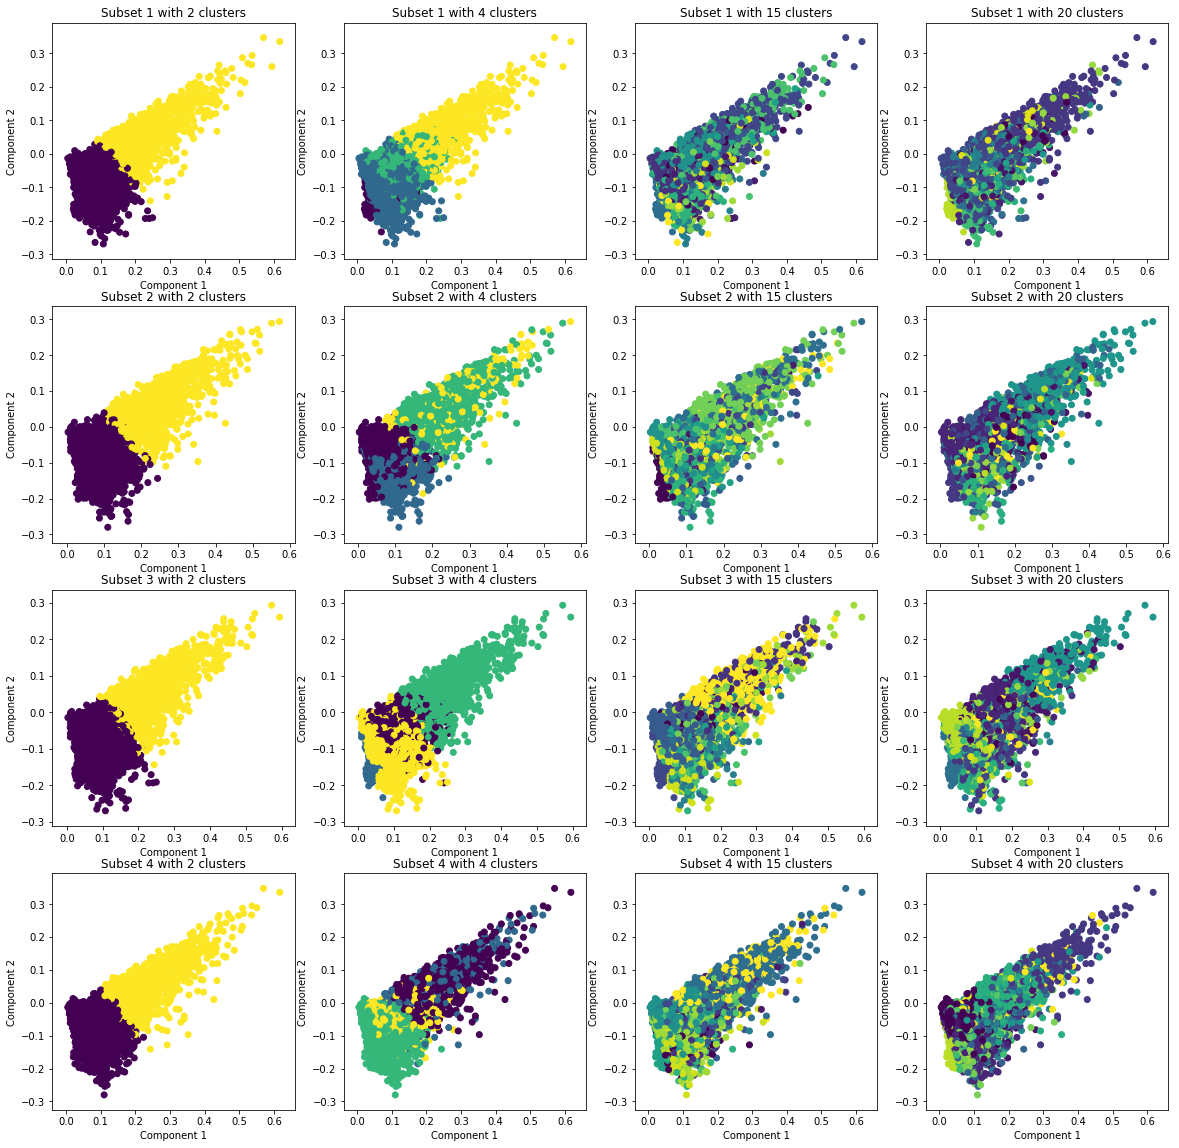

In [77]:
# Split the data to test for consistent clustering
lsa1, lsa2= train_test_split(LSA, test_size=0.50)
lsa3, lsa4= train_test_split(LSA, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,4,len(genres), 20)

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = KMeans(n_clusters=nclust, random_state=42).fit(data)
        preds[row, nclust] = models[row, nclust].predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [78]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', round(metrics.adjusted_rand_score(train['Genre'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['Genre'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 15)

Adjusted Rand index for 2 clusters: 0.02413
The silhouette coefficient for 2 clusters: 0.0053 

Adjusted Rand index for 4 clusters: 0.04185
The silhouette coefficient for 4 clusters: 0.0049 

Adjusted Rand index for 15 clusters: 0.03449
The silhouette coefficient for 15 clusters: 0.0064 

Adjusted Rand index for 20 clusters: 0.03206
The silhouette coefficient for 20 clusters: 0.0107 



Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,10,12,25,13,26,18,5,28,24,3,28,9,4,11,2
1,178,301,275,199,230,462,61,503,344,172,213,164,242,140,54
2,21,27,41,31,19,65,7,11,47,27,12,20,36,30,10
3,52,25,20,60,6,23,14,7,20,52,8,6,22,70,8
4,0,1,0,0,6,16,0,133,0,0,0,1,0,0,0
5,109,18,16,85,5,8,30,0,17,113,6,20,5,135,9
6,62,10,13,66,1,2,38,1,15,60,81,4,8,97,13
7,11,51,59,17,47,40,9,6,34,7,47,29,46,16,3
8,98,64,35,69,10,10,10,15,36,50,22,43,23,48,14


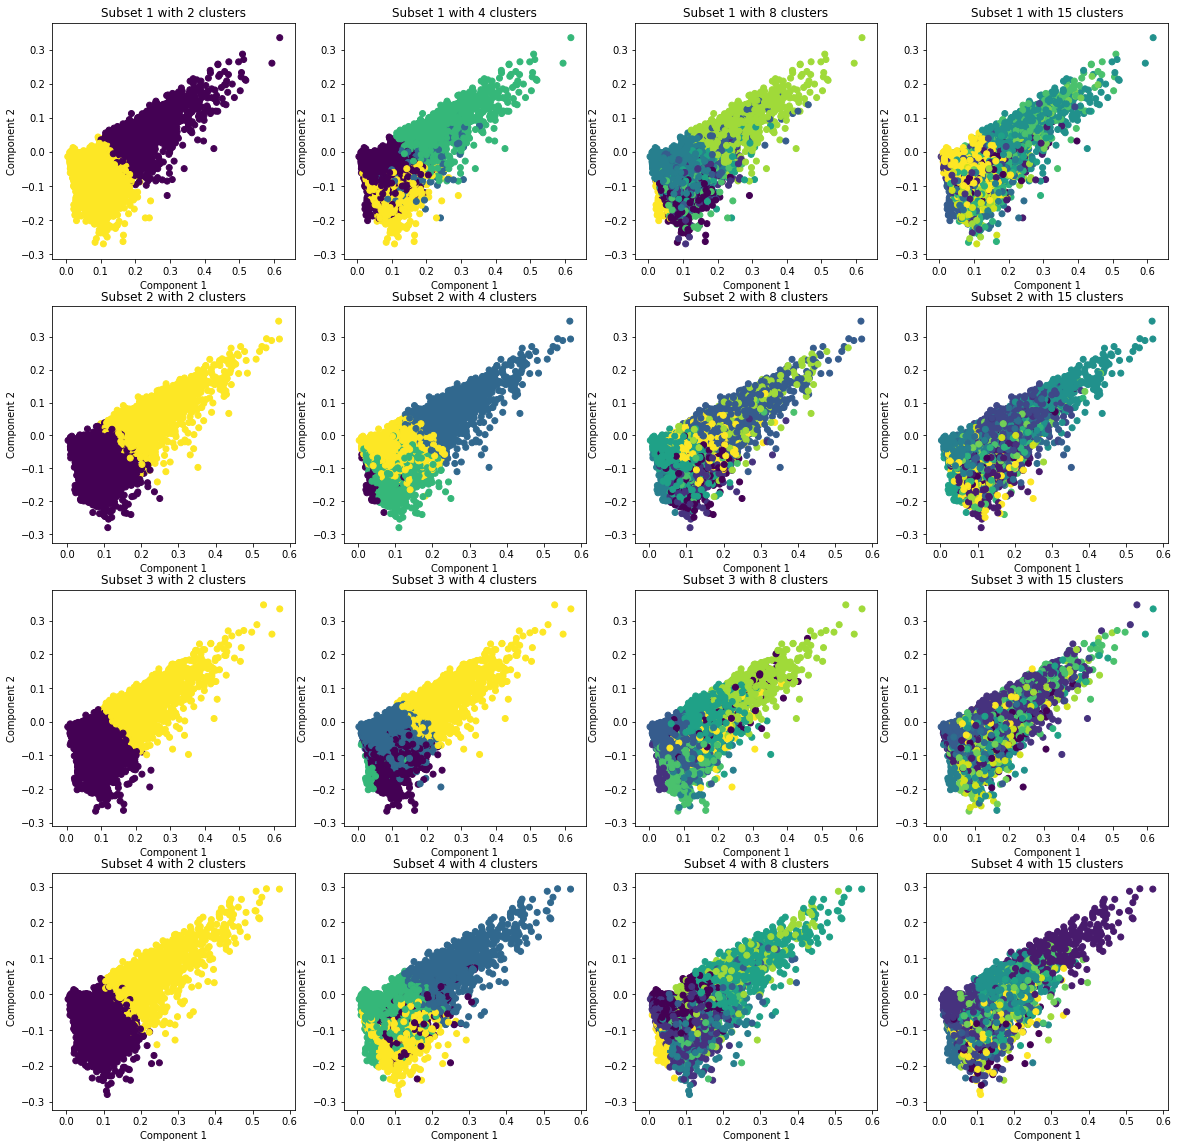

In [133]:
# Split the data to test for consistent clustering
lsa1, lsa2= train_test_split(x_train_LSA1000, test_size=0.50)
lsa3, lsa4= train_test_split(x_train_LSA1000, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,4,8, len(genres))

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, x_train_LSA1000]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = KMeans(n_clusters=nclust, random_state=42).fit(data)
        preds[row, nclust] = models[row, nclust].predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [134]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', round(metrics.adjusted_rand_score(train['Genre'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['Genre'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 15)

Adjusted Rand index for 2 clusters: 0.02413
The silhouette coefficient for 2 clusters: 0.0053 

Adjusted Rand index for 4 clusters: 0.04185
The silhouette coefficient for 4 clusters: 0.0049 

Adjusted Rand index for 8 clusters: 0.05377
The silhouette coefficient for 8 clusters: 0.0056 

Adjusted Rand index for 15 clusters: 0.03449
The silhouette coefficient for 15 clusters: 0.0064 



Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,10,12,25,13,26,18,5,28,24,3,28,9,4,11,2
1,178,301,275,199,230,462,61,503,344,172,213,164,242,140,54
2,21,27,41,31,19,65,7,11,47,27,12,20,36,30,10
3,52,25,20,60,6,23,14,7,20,52,8,6,22,70,8
4,0,1,0,0,6,16,0,133,0,0,0,1,0,0,0
5,109,18,16,85,5,8,30,0,17,113,6,20,5,135,9
6,62,10,13,66,1,2,38,1,15,60,81,4,8,97,13
7,11,51,59,17,47,40,9,6,34,7,47,29,46,16,3
8,98,64,35,69,10,10,10,15,36,50,22,43,23,48,14


# Spectral Clustering

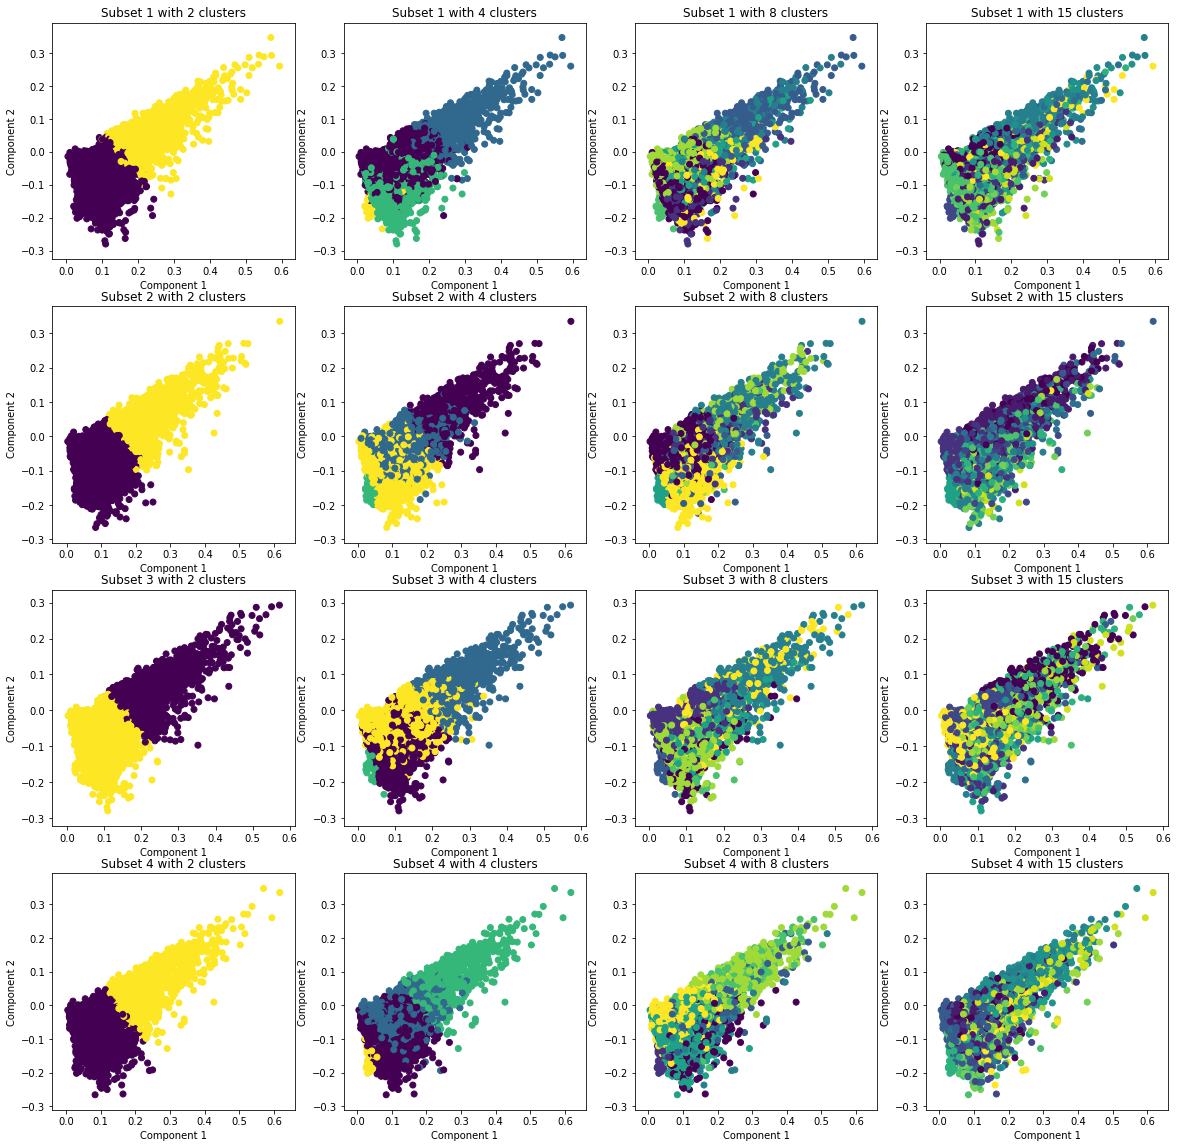

In [143]:
# Split the data to test for consistent clustering
lsa1, lsa2= train_test_split(LSA, test_size=0.50)
lsa3, lsa4= train_test_split(LSA, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,4,8, len(genres))

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = SpectralClustering(n_clusters=nclust).fit(data)
        preds[row, nclust] = models[row, nclust].fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [144]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', round(metrics.adjusted_rand_score(train['Genre'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['Genre'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 15)

Adjusted Rand index for 2 clusters: 0.01958
The silhouette coefficient for 2 clusters: 0.0047 

Adjusted Rand index for 4 clusters: 0.04334
The silhouette coefficient for 4 clusters: 0.0035 

Adjusted Rand index for 8 clusters: 0.04431
The silhouette coefficient for 8 clusters: 0.0037 

Adjusted Rand index for 15 clusters: 0.04659
The silhouette coefficient for 15 clusters: 0.0076 



Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,49,44,31,42,26,43,20,29,65,34,31,11,29,45,15
1,67,11,16,60,1,4,34,1,15,55,95,6,10,91,5
2,9,24,50,13,116,41,7,9,33,9,97,14,16,13,6
3,53,312,270,99,359,356,49,570,291,57,209,200,192,68,34
4,34,16,16,48,7,11,19,3,20,35,9,22,11,77,7
5,53,25,22,70,7,23,14,7,20,55,9,6,18,83,8
6,170,63,43,132,16,43,41,8,46,133,29,35,23,149,26
7,47,19,23,50,7,14,9,10,19,53,8,17,12,63,18
8,290,63,52,257,18,167,31,29,103,234,72,16,53,189,33


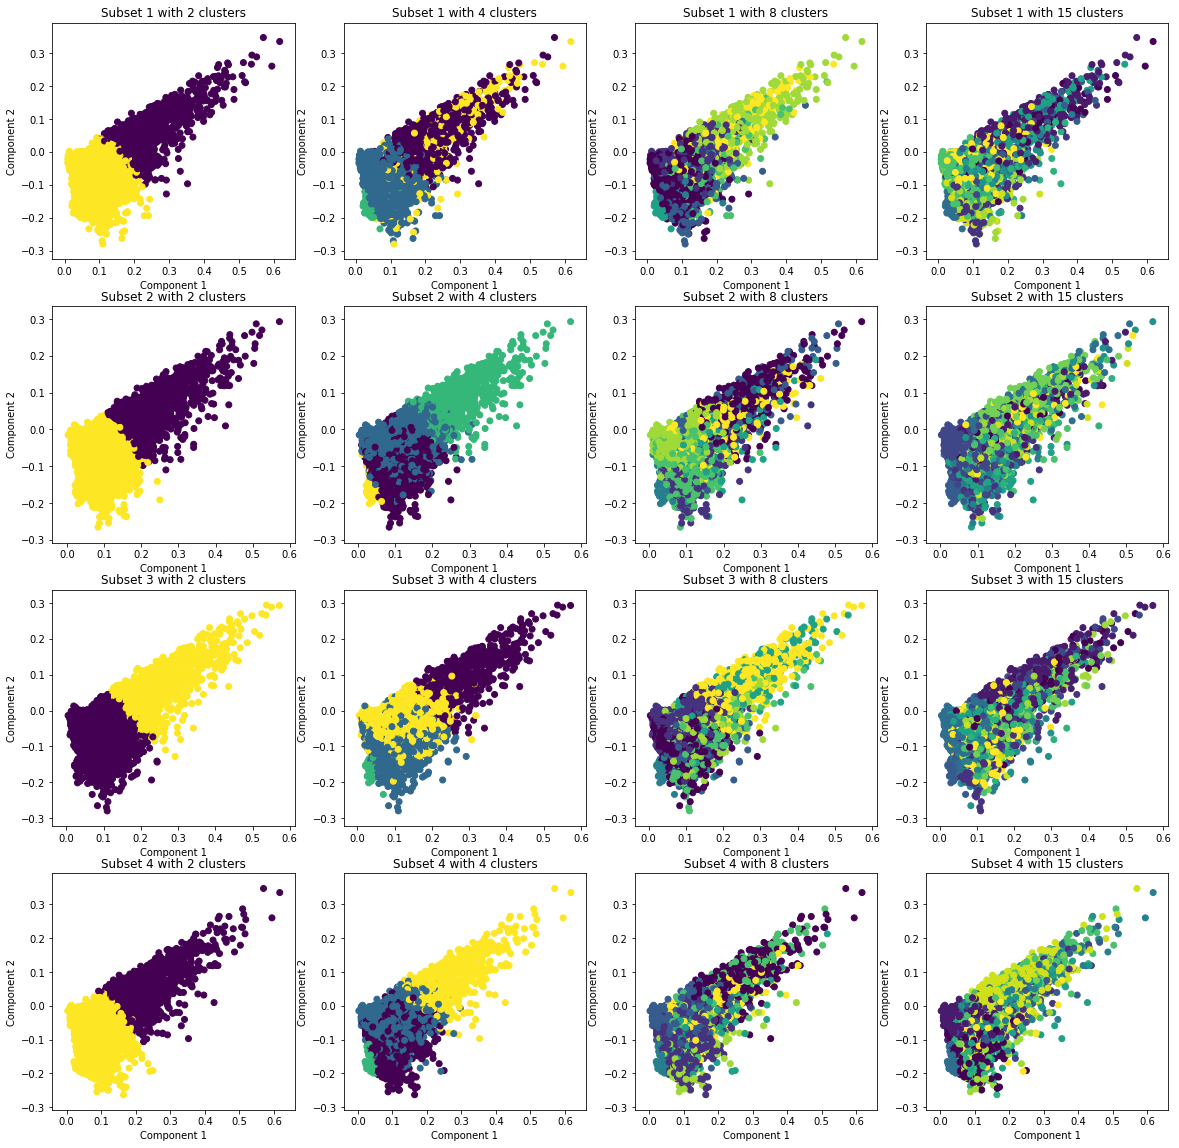

In [145]:
# Split the data to test for consistent clustering
lsa1, lsa2= train_test_split(x_train_LSA1000, test_size=0.50)
lsa3, lsa4= train_test_split(x_train_LSA1000, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,4,8, len(genres))

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = SpectralClustering(n_clusters=nclust).fit(data)
        preds[row, nclust] = models[row, nclust].fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [146]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', round(metrics.adjusted_rand_score(train['Genre'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['Genre'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 15)

Adjusted Rand index for 2 clusters: 0.01955
The silhouette coefficient for 2 clusters: 0.0047 

Adjusted Rand index for 4 clusters: 0.04342
The silhouette coefficient for 4 clusters: 0.0035 

Adjusted Rand index for 8 clusters: 0.04428
The silhouette coefficient for 8 clusters: 0.0037 

Adjusted Rand index for 15 clusters: 0.0468
The silhouette coefficient for 15 clusters: 0.0075 



Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,67,11,16,60,1,4,34,1,15,55,96,6,10,90,5
1,169,60,41,128,14,42,39,7,44,130,26,36,22,151,25
2,101,67,33,70,12,6,14,14,40,48,20,52,16,56,12
3,51,310,265,97,353,352,47,571,289,53,207,200,192,70,35
4,292,66,56,264,23,174,36,29,111,241,77,18,55,188,33
5,0,1,0,0,3,2,0,91,0,0,0,0,0,0,0
6,9,40,50,17,36,38,7,3,30,9,39,41,44,17,3
7,0,32,65,4,114,8,0,8,22,0,47,5,9,3,3
8,10,9,28,18,13,6,11,1,12,32,63,0,30,18,0


K-means with 8 clusters and using the LSA with 1,000 component seems to obtain the best results according to the Adjusted Rand Index, however, the results are not much better than random clustering. 

# Clusters with Holdout data 

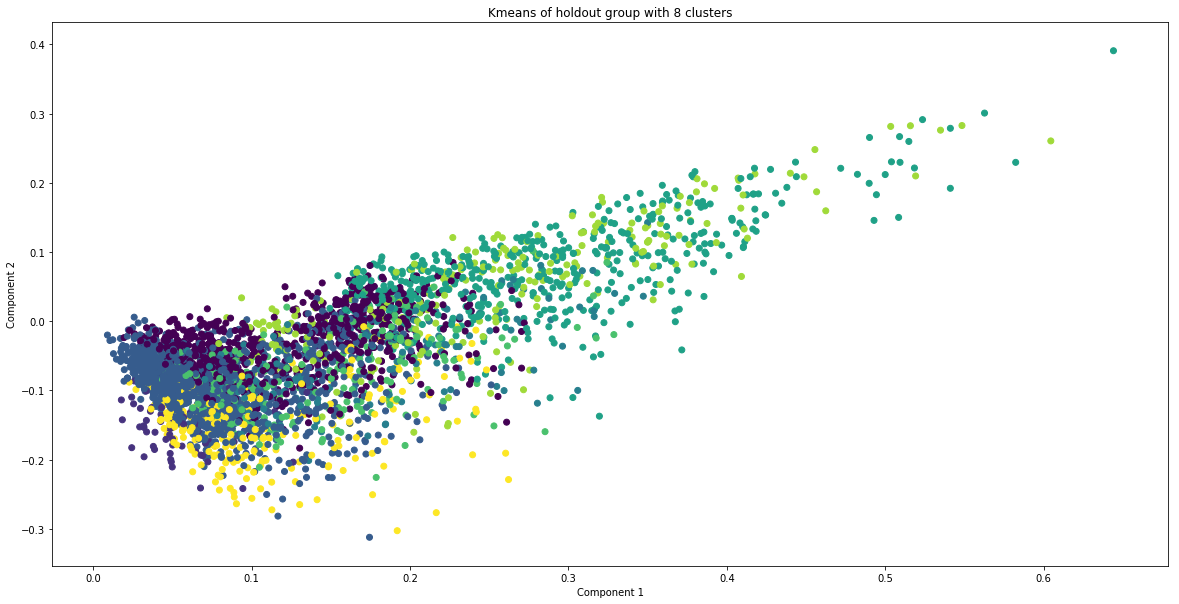

In [135]:

plt.figure(figsize=(20,10))

preds = KMeans(n_clusters=8).fit_predict(x_test_LSA1000)
plt.scatter(x_test_LSA1000[:, 0], x_test_LSA1000[:, 1], c=preds)
plt.title('Kmeans of holdout group with 8 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
        
plt.show()

In [136]:
print('Adjusted Rand index for 8 clusters:', round(metrics.adjusted_rand_score(y_test, preds),5))

pd.crosstab(y_test, preds).T



Adjusted Rand index for 8 clusters: 0.04739


Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,129,48,31,117,3,50,24,8,58,89,57,16,23,95,15
1,0,0,0,0,0,4,0,60,1,0,0,0,0,0,0
2,18,113,119,31,128,138,24,165,112,16,92,76,69,26,20
3,33,24,6,22,5,3,4,1,20,16,8,16,9,23,4
4,86,26,29,68,5,15,19,3,13,78,12,17,9,94,12
5,14,13,25,23,13,34,9,1,28,9,18,10,18,19,0
6,47,13,13,25,1,3,8,0,9,22,36,7,4,53,11
7,2,26,46,4,63,17,3,3,20,4,48,9,11,6,1


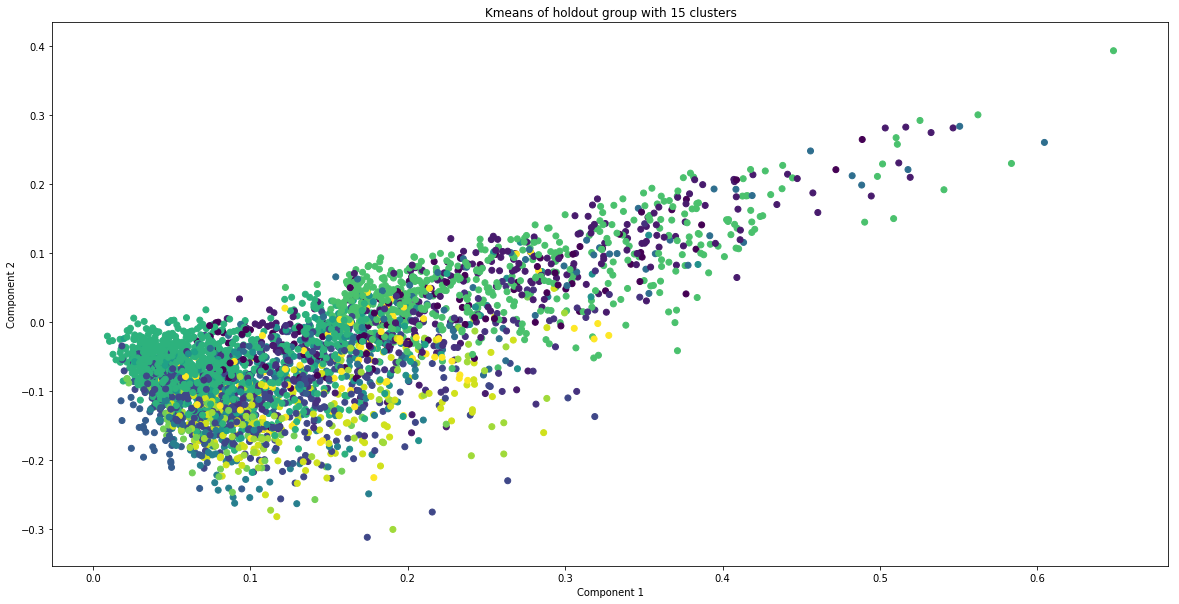

In [165]:

plt.figure(figsize=(20,10))

preds = KMeans(n_clusters=15).fit_predict(x_test_LSA1000)
plt.scatter(x_test_LSA1000[:, 0], x_test_LSA1000[:, 1], c=preds)
plt.title('Kmeans of holdout group with 15 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
        
plt.show()

In [166]:
print('Adjusted Rand index for 15 clusters:', round(metrics.adjusted_rand_score(y_test, preds),5))

pd.crosstab(y_test, preds).T



Adjusted Rand index for 15 clusters: 0.03112


Genre,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
col_0,,,,,,,,,,,,,,,
0,22,8,3,24,0,8,4,1,6,15,2,1,3,25,4
1,48,9,9,22,1,3,6,0,7,15,33,6,3,50,11
2,28,24,8,21,4,1,3,0,18,14,7,14,6,20,3
3,4,68,72,5,51,24,2,36,43,2,25,46,18,6,9
4,0,0,0,0,0,4,0,58,1,0,0,0,0,0,0
5,10,6,8,19,4,0,4,1,6,22,2,4,1,13,5
6,0,9,15,2,33,2,0,4,7,0,21,3,1,0,0
7,11,14,8,14,1,10,3,2,14,2,3,7,8,10,0
8,9,12,4,11,11,24,3,8,9,2,3,6,9,9,2


The Rand Index for K-means with 8 clusters and using the LSA with 1000 components achieved a similar Rand index that the obtained with the train data. On the other hand, the 15 clusters version didn't do as well with the test data as it did with the train data. 

## Conclusion

The Brown Corpus contains a wide variety of texts and categories, so it is difficult to build models that predict with high accuracy. Still, Logistic Regression did a good job classifying the sentences, with an accuracy of over 60%. Clustering was pretty scattered for both K-Means and Spectral clustering on both the test and holdout groups.